In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import math
import pandas as pd
import pickle
import time
from tqdm.notebook import tnrange

In [2]:
epochs = 300
size = 100
#ReqLabels = [1,3,5,7,14]#,17,19,20,26,33,34,36,37,38,39]
ReqLabels = [1,3,5,7,14,17,26,33,34,36,37]
#ReqLabels = [1,14,38,39]
Train_Path = '/home/student/Downloads/Traffic Signs/Train.csv'
Test_Path = '/home/student/Downloads/Traffic Signs/Test.csv'
Meta_Path = '/home/student/Downloads/Traffic Signs/Meta.csv'
Labels_Path = '/home/student/Downloads/Traffic Signs/Labels.csv'

Labels = []
labelData = pd.read_csv(Labels_Path)
for i,j in zip(labelData['ClassId'] , labelData['SignName']) :
    if i in ReqLabels :
        Labels.append(j)
        
print(Labels)

### 30 , 50 , 70 , 100 km/h and No entry , Stop , 19,20,27,33,34,35,36,37,38,39

['Speed limit (30km/h)', 'Speed limit (60km/h)', 'Speed limit (80km/h)', 'Speed limit (100km/h)', 'Stop', 'No entry', 'Traffic signals', 'Turn right ahead', 'Turn left ahead', 'Go straight or right', 'Go straight or left']


### Train Data Loding

### Test Data Loading

In [3]:
loc = 'LoadedData.obj'

In [4]:
f = open(loc , 'rb')
X_train , X_test ,Y_train , Y_test = pickle.load(f)

In [5]:
fileName = 'Model_Batch_1.0.obj'
def callback(obj,fileName) :
    print('CallBack : ',fileName,'Updated')
    f = open(fileName, 'wb') 
    pickle.dump(obj, f)

In [6]:
print(f'X_train shape : {X_train.shape}, Y_train shape : {Y_train.shape}')
print(f'X_test shape : {X_test.shape}, Y_test shape : {Y_test.shape}')

X_train shape : (5020, 100, 100, 3), Y_train shape : (5020,)
X_test shape : (1060, 100, 100, 3), Y_test shape : (1060,)


### Activations

In [7]:
class ReLU :
    def __init__ (self) :
        self.__type__ = 'activation'
        self.__Name__ = 'ReLU'
    
    def feed(self,X) :
        self.input = X
        self.input_shape=X.shape
        self.output = np.maximum(0,X)
        self.output_shape = self.input_shape
        return self.output
    
    def feed_back(self,Z,grad_output,lr) :
        grad = Z > 0
        #print(grad.shape,grad_output.shape)
        return grad_output*grad
    
class TanH :
    def __init__(self) :
        self.__type__ = 'activation'
        self.__Name__ = 'TanH'
    def feed(self,X) :
        self.input = X
        self.input_shape = X.shape
        self.output = (np.exp(X)-np.exp(-X))/(np.exp(X)+np.exp(-X))
        self.output_shape = self.output.shape
        return self.output
        
    def feed_back(self,Z,grad_output,lr) :
        return 1-np.power(self.output,2)
        
class Softmax :
    def __init__ (self) :
        self.__type__ = 'activation'
        self.__Name__ = 'Softmax'
    
    def feed(self,X) :
        self.input = X
        #e_x = np.exp(X-np.max(X))
        self.output = np.exp(X)/np.sum(np.exp(X))
        return self.output
    
    def grad_feed(self,X) :
        e_x = np.exp(X)
        return (e_x/e_x.sum()) - (np.power(e_x,2)/np.power(e_x.sum(),2))
    
    def feed_back(self,Z,grad_output,lr) :
        e_x = np.exp(Z)
        out = e_x/ex.sum()
        grad = (e_x/e_x.sum()) - (np.power(e_x,2)/np.power(e_x.sum(),2))
        #grad = e_x/e_x.sum()**2 - (e_x**2/(e_x.sum()**2))
        return grad_output*grad
    
class Sigmoid :
    def __init__ (self) :
        self.__type__ = 'activation'
        self.__Name__ = 'Sigmoid'
    
    def feed(self,X) :
        self.input = X
        self.output = 1/(1+np.exp(-X))
        return self.output
    
    def grad_feed(self,X) :
        out = 1/(1+np.exp(-X))
        return out*(1-out)
    
    def feed_back(self,Z,grad_output,lr) :
        out = 1/(1+np.exp(-Z))
        grad = out*((1-out)**2)
        return grad_output*grad

### Layers

In [8]:
class Flatten :
    
    """
        Flatten class is used to convert data into single dimension
    """
    
    def __init__ (self,input_shape=None,output_shape=None,__Name__='Flatten') : ### Constructor called when we create object 
        self.__Name__ = __Name__ ### Defining __Name__ variable with Flatten
        self.__type__ = 'flat' ### Defining __type__ variable
        self.input_shape = input_shape
        self.A_F = None
        re = 1
        if output_shape is None :
            for i in input_shape :
                re *= i
            self.output_shape = re
        else :
            self.output_shape = output_shape
        
    def feed(self,X) : ### feed function is used to transforms data into single dimension
        #self.input = X
        self.output = X.ravel() ### ravel is used to convert data into single dimensoin or flattens data
        return self.output
    
    def feed_back(self,X,output_error) :
        return X.reshape(self.input_shape)
    
    def Summary(self) :
        l = len(self.__Name__)
        print(f'{self.__Name__}',' '*(20-l),self.input_shape,' '*(20-len(str(self.input_shape))),self.output_shape)

In [9]:
class Dense :
    
    def __init__ (self,input_shape,N_F,A_F=None,wt=None,bias=None,output_shape=None,__Name__='Dense') :
        
        """
            Wt and Bias range [-2.4/No of nodes , 2.4/No of nodes] Proposed by range
        """
        self.__Name__ = __Name__
        self.__type__ = 'dense'
        self.input_shape = input_shape
        self.N_F = N_F
        self.A_F = A_F
        if output_shape is None :
            self.output_shape = N_F
        else :
            self.output_shape = output_shape
        if wt is None :
            self.weights = np.random.uniform(-2.4/self.N_F,2.4/self.N_F,(self.input_shape, self.output_shape))
        else :
            self.weights = wt
        if bias is None :
            self.bias = np.random.uniform(-2.4/ self.N_F,2.4/ self.N_F,(1, self.output_shape))
            #self.bias = np.zeros((1, self.output_shape))
        else :
            self.bias = bias
        self.Batch_W = []
        self.Batch_B = []
        self.v_ = np.zeros((self.input_shape, self.output_shape))
        self.s_ = np.zeros((self.input_shape, self.output_shape))
        
    def feed(self,X) :
        if X.shape[0] != 1 :
            output = []
            output.append(X)
            self.input = np.array(output)
        else :
            self.input = X
        self.output = np.matmul(X,self.weights) + self.bias
        return self.output

    def feed_back(self, Z , output_error, learning_rate=[1e-03],decay=1e-01,opt='sgd'):
        input_error = np.dot(output_error,self.weights.T)
        #output_error = output_error.mean(axis=0)*Z.T.shape[0]
        weights , bias = None , None
        weights_error = np.dot(Z.T, output_error)
        #input_error = np.dot(input_error.T,output_error)
        lr = learning_rate[np.random.randint(len(learning_rate))]
        #print(output_error.shape,input_error.shape,Neww.shape,weights_error.shape)
        if opt.lower() == 'gd' :
                weights = self.weights - lr * weights_error
                bias = self.bias - lr * output_error
        elif opt.lower() == 'sgd' :
                weights = self.weights - lr * weights_error - lr * (decay/self.N_F) * input_error
                bias = self.bias - lr * (decay/self.N_F) * output_error
        elif opt.lower() == 'rmsprop' :
                self.v_ = decay * self.v_ - lr * weights_error
                weights = self.weights - self.v_ #- learning_rate * weights_error
                bias = self.bias - lr * output_error
        elif opt.lower() == 'adam' :
                b1=.9
                b2=.99
                self.v_ = b1 * self.v_ + (1-b1) * weights_error
                self.s_ = b2 * self.s_ + (1-b2) * np.power(weights_error , 2)
                self.V_ = self.v_ / (1-b1)
                self.S_ = self.s_ / (1-b2)
                weights = self.weights - lr * (self.V_ / (np.sqrt(np.maximum(self.S_,0))+ decay)) * weights_error
                bias = self.bias - lr * output_error
        return (weights , bias , input_error)
    
    def Summary(self) :
        l = len(self.__Name__)
        print(f'{self.__Name__}',' '*(20-l),self.input_shape,' '*(20-len(str(self.input_shape))),self.output_shape)

In [10]:
def PlotAcc(model) : ### Accuracy Plot
    plt.plot(range(model.ep),model.acc,c='r',label='acc')
    plt.plot(range(model.ep),model.val_acc,c='b',label='val_acc')
    plt.legend()
    plt.show()

def PlotError(model) : ### Error Plot
    plt.plot(range(model.ep),model.error,c='black',label='error')
    plt.legend()
    plt.show()

In [11]:
class Sequential :
    
    """
        Sequential is a class which is used to stack layers of model and to fit , predict , predicting classes of our given i/p
    """
    
    def __init__ (self) :
        self.Layers = []
        self.input_shape = None
        self.Activations = []
        self.acc = []
        self.val_acc = []
        self.error = []
        self.val_error = []
        self.id = 1
        self.ep = 1
        
    def add(self,Layer) :
        boo = False
        for layer in self.Layers :
            if Layer.__type__ == layer.__type__ :
                boo = True
                if '_' not in Layer.__Name__ :
                    Layer.__Name__ += '_'+str(self.id)
                name,k = Layer.__Name__.split('_')
                Layer.__Name__ = name+'_'+str(int(k)+1)
        if not boo :
            if '_' not in Layer.__Name__ :
                Layer.__Name__ += '_'+str(self.id)
        
        self.Layers.append(Layer)
        if Layer.__type__ != 'activation' :
            if self.input_shape is None :
                self.input_shape = Layer.input_shape
            self.output_shape = Layer.output_shape
        if Layer.A_F is not None :
            if Layer.A_F.lower() == 'softmax' :
                self.Activations.append(Softmax())
            elif Layer.A_F.lower() == 'sigmoid' :
                self.Activations.append(Sigmoid())
            elif Layer.A_F.lower() == 'tanh' :
                self.Activations.append(TanH())
            else :
                self.Activations.append(ReLU())
        else :
            self.Activations.append(None)
    def ShuffleData(self,X,Y) :
        order = np.random.randint(len(Y))
        for i in range(len(Y)-1) :
            X[order[i]] , X[order[i+1]] = X[order[i+1]] , X[order[i]]
            Y[order[i]] , Y[order[i+1]] = Y[order[i+1]] , Y[order[i]]
        return (X , Y)
    
    def SplitData(self,X,Y,split) :
        input_data , output_data , val_input_data , val_output_data = None , None , None , None
        N = int(len(Y) * (1-split))
        while True :
            X , Y = self.ShuffleData(X,Y)
            if set(Y[:N]) != set(Y[N:]) :
                X ,Y = self.ShuffleData(X,Y)
            else :
                input_data , output_data = X[:N] , Y[:N]
                val_input_data , val_output_data = X[N:] , Y[N:]
                break
        return (input_data , output_data , val_input_data , val_output_data)
        
    def compile(self,optimizer='sgd',loss='cross_entropy',metrics=['acc']) :
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        
    def one_hot_encode(self,l) :
        Labels = np.zeros(self.Layers[-1].output_shape)
        Labels[l] = 1
#         for i,label in enumerate(labels) :
#             Labels[i][label] = 1
        return Labels

    def trainModel(self , b , X , Y , lr,decay) : ### X and Y -> batch size of x and batch size of y and training model batch wise
        c = 0
        error = None
        for x,y in zip(X,Y) :
            # Training model
            output = x
            loss = None
            
            """
                Forward Feeding
            """
            
            #print(self.Layers , self.Activations)
            
            L_INPUTS , L_OUTPUTS , A_INPUTS , A_OUTPUTS = [] , [] , [] , []
            
            for layer , activation in zip(self.Layers , self.Activations) :
                L_INPUTS.append(output)
                output = layer.feed(output)
                L_OUTPUTS.append(output)
                if activation is not None :
                    A_INPUTS.append(output)
                    output = activation.feed(output)
                    A_OUTPUTS.append(output)
            
            """
                Loss Calculation
            """
            
            if self.loss == 'cross_entropy' :
                loss = self.cat_crossentropy(A_OUTPUTS[-1],Y)
                if math.isnan(loss) :
                    return None
                grad_activation = self.Activations[-1].grad_feed(L_OUTPUTS[-1])
                out_err = self.grad_crossentropy(L_OUTPUTS[-1],Y)*grad_activation
            
            """
                Backward Feeding
            """
            try :
                for i in range(1,len(self.Layers)-1) :
                    if self.Layers[-i].__Name__[0] != 'F' :
                        if self.Activations[-i].__Name__ != 'Softmax' :
                            out_err = self.Activations[-i].feed_back(A_INPUTS[-i],out_err,lr)
                        w , b_ , out_err = self.Layers[-i].feed_back(L_INPUTS[-i],out_err,lr,decay,opt=self.optimizer)
                        self.Layers[-i].Batch_W.append(w)
                        self.Layers[-i].Batch_B.append(b_)
                    else :
                        break
            except Exception as e :
                    print(e)
                    pass
                
            error = np.mean(loss)
            c += 1
            #print('\rbatch = %d , c = %d , error=%f' % (b,c,error),end="")
            print('\r Loss : %f ' % (error) , end="")
            
        for i in range(1,len(self.Layers)-1) :
            if self.Layers[-i].__Name__[0] != 'F' :
                Batch_W = np.array(self.Layers[-i].Batch_W)
                Batch_B = np.array(self.Layers[-i].Batch_B)
                self.Layers[-i].weights = np.mean(self.Layers[-i].Batch_W , axis = 0)
                self.Layers[-i].bias = np.mean(self.Layers[-i].Batch_B)
                self.Layers[-i].Batch_W = []
                self.Layers[-i].Batch_B = []
                
        return error
            
    def fit(self,train_data,valid_data=None,validation_split=.2,epochs=10,lr=1e-02,decay=1e-03,batch_size=8,model_updation_epoch=2,PlotView=10) :
        self.epochs = epochs
        self.batch_size = batch_size
        input_data , output_data = None , None
        val_input_data , val_target_data = None , None
        if train_data is None :
            raise ValueError('Training Data Required')
        else :
            input_data = train_data[0]
            output_data = train_data[1]
        N = len(input_data)
        
        if valid_data is None :
            input_data , output_data , val_input_data , val_output_data = self.SplitData(input_data , output_data , validation_split)
        else :
            val_input_data , val_target_data = valid_data[0] , valid_data[1]
        print('\nModel Fitting\n')
        
        N = len(output_data)
#         input_data = normalize(input_data,axis=0)
#         val_input_data = normalize(val_input_data,axis=0)
        for ep in range(epochs) :
            model.ep = ep + 1
            start_ep = time.time()
            error = 0
            acc = 0
            print(f'\nepoch : {ep+1}/{epochs}')
            
            for b,batch in enumerate(tnrange(0,N-batch_size+1,batch_size,desc='batch')) :
                #print(b,batch)
                X , Y = input_data[batch:batch+batch_size] , output_data[batch : batch+batch_size]
                error = self.trainModel(b , X , Y , lr , decay)
                while error is None :
                    model.ep = ep - 1
                    #error = self.trainModel(b , X , Y , lr)
                    callback(model,fileName)
                    loop_break = True
                    return self
            
            ### Accuracy , Val_Accuracy , Loss , Val_loss
#             if loop_break :
#                 break
            accuracy = sum([y == np.argmax(model.predict(x)) for x, y in zip(input_data, output_data)]) / N
            self.acc.append(accuracy)
            self.error.append(error)
            
            if 'acc' in self.metrics :
                val_accuracy = sum([y == np.argmax(model.predict(x)) for x, y in zip(val_input_data, val_target_data)]) / len(val_input_data)
                self.val_acc.append(val_accuracy)
                print(' acc=%f , val_acc=%f' % (accuracy , val_accuracy))
            else :
                print('\racc=%f' % (accuracy))
            callback(model,fileName)
            
            if not (ep+1)%PlotView :
                PlotAcc(self)
                PlotError(self)
            
            #end_ep = time.time()
            
            #print(f'Time Taken for epoch {ep+1} : {end_ep-start_ep}s')1e-0*3, 2060 6GB GDDR6 (OC Ready)


        return self
    
    def mse(self,y_true, y_pred):
        return np.mean(np.power(y_true - y_pred, 2))
    
    def mse_prime(self,y_true, y_pred):
        return 2 * (y_pred - y_true) / y_pred.size
    
    def transfer_derivative(self,output):
        return output * (1.0 - output)
    
    def binary_crossentropy(self,pred,Truth) :
        GroundTruth = np.zeros(self.No_of_outs)
        GroundTruth[Truth] = 1
        return -np.mean(GroundTruth*np.log(pred)+(1-GroundTruth)*np.log(1-pred))
    
    def binary_grad_crossentropy(self,pred,Truth) :
        GroundTruth = np.zeros(self.No_of_outs)
        GroundTruth[Truth] = 1
        return -((GroundTruth/pred)-((1-GroundTruth)/(1-pred)))
    
    def cat_crossentropy(self,pred,Truth) :
        Truth = self.one_hot_encode(Truth)
#         a = Truth/pred
#         b = self.Activations[-1].grad_feed(self.Layers[-1].output)[0]
#         print(Truth,pred,a,b)
#         print(np.dot(a,b.T))
        return np.dot((Truth/pred),self.Activations[-1].grad_feed(self.Layers[-1].output)[0])

    def grad_cat_crossentropy(self,pred,Truth) :
        Truth = self.one_hot_encode(Truth)
        a = Truth/pred
        b = self.Activations[-1].grad_feed(self.Layers[-1].output)[0]
        print(Truth,pred,a,b)
        print(np.dot(a,b.T))
        return np.dot((Truth/pred),self.Activations[-1].grad_feed(self.Layers[-1].output)[0])
    
    def crossentropy(self,logits,reference_answers):
        return - logits[0][reference_answers] + np.log(np.sum(np.exp(logits),axis=-1))
    
    def grad_crossentropy(self,logits,reference_answers):
        ones_for_answers = np.zeros_like(logits)
        ones_for_answers[np.arange(len(logits)),reference_answers] = 1
        softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
        return (- ones_for_answers + softmax) / logits.shape[0]
    
    def showImg(self,X) :
        plt.imshow(X)
        plt.show()
    
    def predict(self,X):
        outputs = []
        if X.shape == model.input_shape :
            output = X
            for layer , activation in zip(self.Layers,self.Activations) :
                output = layer.feed(output)
                if activation is not None :
                    output = activation.feed(output)
            outputs.append(output)
        else :
            for output in X :
                for layer , activation in zip(self.Layers,self.Activations) :
                    output = layer.feed(output)
                    if activation is not None :
                        output = activation.feed(output)
                outputs.append(output)
        return np.array(outputs)
    
    def pred_class(self,X) :
        classes = []
        if X.shape == model.input_shape :
            output = self.predict(X)
            return np.argmax(output)
        else :
            for output in X :
                output = self.predict(output)
                classes.append(np.argmax(output))
            return np.array(classes)
    
    def Summary(self) :
        print('='*60)
        print('Model Summary')
        print('_'*60)
        print('Layers',' '*(20-len('Layers')),'Input Shape',' '*(20-len('Input Shape')),'Output Shape',' '*(20-len('Output Shape')))
        print('='*60)
        for Layer in self.Layers :
            if Layer.__type__ != 'activation' :
                Layer.Summary()
                print('_'*60)
        print('='*60)

In [12]:
model = Sequential()
model.add(Flatten(input_shape=X_train[0].shape))
model.add(Dense(input_shape=model.output_shape,N_F=100,A_F='TanH')) ### Input Layer
#model.add(Dense(input_shape=model.output_shape,N_F=32,A_F='ReLU')) ## Hidden Layer
model.add(Dense(input_shape=model.output_shape,N_F=len(set(Y_train)),A_F='Softmax')) ### Output Layer
model.compile(optimizer='gd',loss='cross_entropy',metrics=['acc'])

model.Summary()

Model Summary
____________________________________________________________
Layers                Input Shape           Output Shape         
Flatten_1             (100, 100, 3)         30000
____________________________________________________________
Dense_1               30000                 100
____________________________________________________________
Dense_2               100                   11
____________________________________________________________



Model Fitting


epoch : 1/300


 Loss : 0.856879 
 acc=0.085458 , val_acc=0.116981
CallBack :  Model_Batch_1.0.obj Updated

epoch : 2/300


 Loss : 0.826500 
 acc=0.145618 , val_acc=0.153774
CallBack :  Model_Batch_1.0.obj Updated

epoch : 3/300


 Loss : 0.765014 
 acc=0.189442 , val_acc=0.198113
CallBack :  Model_Batch_1.0.obj Updated

epoch : 4/300


 Loss : 0.629533 
 acc=0.195817 , val_acc=0.223585
CallBack :  Model_Batch_1.0.obj Updated

epoch : 5/300


 Loss : 0.444596 
 acc=0.183068 , val_acc=0.223585
CallBack :  Model_Batch_1.0.obj Updated

epoch : 6/300


 Loss : 0.321480 
 acc=0.208765 , val_acc=0.233019
CallBack :  Model_Batch_1.0.obj Updated

epoch : 7/300


 Loss : 0.257660 
 acc=0.256574 , val_acc=0.262264
CallBack :  Model_Batch_1.0.obj Updated

epoch : 8/300


 Loss : 0.222992 
 acc=0.324104 , val_acc=0.295283
CallBack :  Model_Batch_1.0.obj Updated

epoch : 9/300


 Loss : 0.201496 
 acc=0.377092 , val_acc=0.312264
CallBack :  Model_Batch_1.0.obj Updated

epoch : 10/300


 Loss : 0.186473 
 acc=0.418526 , val_acc=0.334906
CallBack :  Model_Batch_1.0.obj Updated


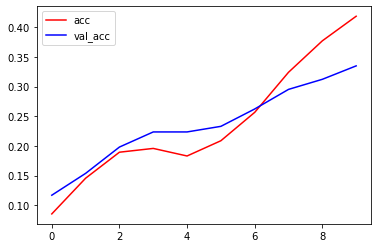

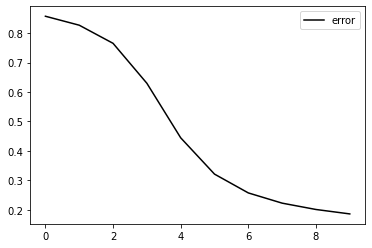


epoch : 11/300


 Loss : 0.175251 
 acc=0.457171 , val_acc=0.366981
CallBack :  Model_Batch_1.0.obj Updated

epoch : 12/300


 Loss : 0.166550 
 acc=0.481076 , val_acc=0.414151
CallBack :  Model_Batch_1.0.obj Updated

epoch : 13/300


 Loss : 0.159618 
 acc=0.503586 , val_acc=0.455660
CallBack :  Model_Batch_1.0.obj Updated

epoch : 14/300


 Loss : 0.153946 
 acc=0.528884 , val_acc=0.489623
CallBack :  Model_Batch_1.0.obj Updated

epoch : 15/300


 Loss : 0.149149 
 acc=0.555578 , val_acc=0.508491
CallBack :  Model_Batch_1.0.obj Updated

epoch : 16/300


 Loss : 0.144931 
 acc=0.578685 , val_acc=0.528302
CallBack :  Model_Batch_1.0.obj Updated

epoch : 17/300


 Loss : 0.141090 
 acc=0.600996 , val_acc=0.544340
CallBack :  Model_Batch_1.0.obj Updated

epoch : 18/300


 Loss : 0.137500 
 acc=0.616135 , val_acc=0.558491
CallBack :  Model_Batch_1.0.obj Updated

epoch : 19/300


 Loss : 0.134087 
 acc=0.627689 , val_acc=0.571698
CallBack :  Model_Batch_1.0.obj Updated

epoch : 20/300


 Loss : 0.130806 
 acc=0.639044 , val_acc=0.583962
CallBack :  Model_Batch_1.0.obj Updated


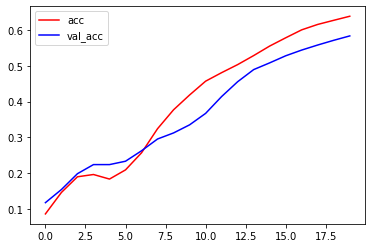

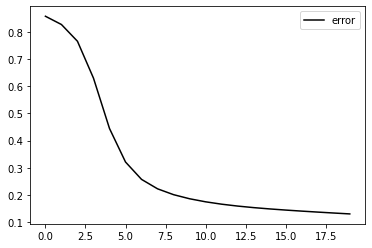


epoch : 21/300


 Loss : 0.127633 
 acc=0.649203 , val_acc=0.595283
CallBack :  Model_Batch_1.0.obj Updated

epoch : 22/300


 Loss : 0.124552 
 acc=0.654980 , val_acc=0.607547
CallBack :  Model_Batch_1.0.obj Updated

epoch : 23/300


 Loss : 0.121556 
 acc=0.659761 , val_acc=0.610377
CallBack :  Model_Batch_1.0.obj Updated

epoch : 24/300


 Loss : 0.118641 
 acc=0.666733 , val_acc=0.614151
CallBack :  Model_Batch_1.0.obj Updated

epoch : 25/300


 Loss : 0.115805 
 acc=0.671315 , val_acc=0.621698
CallBack :  Model_Batch_1.0.obj Updated

epoch : 26/300


 Loss : 0.113046 
 acc=0.675100 , val_acc=0.625472
CallBack :  Model_Batch_1.0.obj Updated

epoch : 27/300


 Loss : 0.110363 
 acc=0.679482 , val_acc=0.630189
CallBack :  Model_Batch_1.0.obj Updated

epoch : 28/300


 Loss : 0.107755 
 acc=0.683865 , val_acc=0.633962
CallBack :  Model_Batch_1.0.obj Updated

epoch : 29/300


 Loss : 0.473758 

In [ ]:
model.fit(train_data=(X_train,Y_train),
          valid_data=(X_test,Y_test),
          epochs=epochs,
          lr=[0.01*5],
          decay=1e-08,
          batch_size=8,
          PlotView=10)

In [ ]:
def SaveModel(obj,fileName) :
    f = open(fileName, 'wb') 
    pickle.dump(obj, f)
    
def loadModel(fileName) :
    f = open(fileName, 'rb') 
    model = pickle.load(f)
    return model

In [ ]:
e-01,1e-01*2,PlotAcc(model)
PlotError(model)

In [ ]:
model.pred_class(X_test)

In [ ]:
model.pred_class(X_train[0])

In [ ]:
c = 0
for i in range(len(X_train)) :
    #print(model.pred_class(X_train[i]),Y_train[i])
    if model.pred_class(X_train[i]) == Y_train[i] :
        c += 1
print(c*100/len(X_train))

In [ ]:
img = X_train[1]
print(model.predict(img))
print(Labels[model.pred_class(img)])
plt.imshow(img)
plt.show()

In [ ]:
img = X_train[100]
print(model.predict(img))
print(Labels[model.pred_class(img)])
plt.imshow(img)
plt.show()